# Swiss Housing Price Predictor 🏠💰

Hello, we are Tobias, Sascha, and Florian. Our goal for this project is to build a predictive model for Swiss housing prices. We aim to achieve this by leveraging current web data. 

![Swiss House](https://archivaldesigns.com/cdn/shop/products/Peach-Tree-Front_1200x.jpg?v=1648224612)

This project will involve several steps:

1. **Data Collection**: Scrape housing data from various online sources.
2. **Preprocessing**: Clean and format the data for analysis.
3. **Exploratory Data Analysis**: Understand the data and find any interesting trends.
4. **Feature Engineering**: Create new features from the existing data to improve our model's performance.
5. **Model Building**: Train a machine learning model on our processed data.
6. **Evaluation**: Test our model's performance and make any necessary adjustments.

Our aim is that our model will be able to accurately predict housing prices, providing valuable insights for both buyers and sellers in the Swiss housing market. 

You can check out our code [here on GitHub](https://github.com/meichflo/ADS_Project_group3).

> "The only way to do great work is to love what you do." - Steve Jobs

# Imports

In [1]:
# Libraries
import os
import re
import json
import time
import random
import pandas as pd

from bs4 import BeautifulSoup

from prettytable import from_csv

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from datetime import datetime

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support import expected_conditions as EC

# Settings
import warnings
warnings.filterwarnings("ignore")

# Current working directory
print(f'Current working directory: {os.getcwd()}')

Current working directory: c:\Users\FMeic\data_science\ADS_Project_group3


# Web (Immoscout24) Scraping

In [7]:
# List of user agents to rotate through
ua_list = ["Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15",
           "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
           "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:88.0) Gecko/20100101 Firefox/88.0"]

# Set up the Chrome driver with a random user agent and headless mode
opts = Options()
opts.add_argument("--headless")
opts.add_argument("user-agent=" + random.choice(ua_list))

#service = Service(executable_path=r'C:\Tools\chromedriver\chromedriver.exe')
service = Service(executable_path=r'/Users/tobiaskoller/Library/CloudStorage/OneDrive-ZHAW/2. Semester/Applied Data Science/tools/chromedriver-mac-x64/chromedriver')

# Chrome-Driver
driver = webdriver.Chrome(service=service, options=opts)

# Base URL of the website to scrape
base_url = 'https://www.immoscout24.ch/de/immobilien/mieten/kanton-zuerich?pn='

# Initialize an empty list to store scraped data
all_detail_urls = []


current_page = 1    # Start with page 1 of the search results
max_pages = 50  # Specify the maximum number of pages to scrape

# Loop through all pages to extract URLs of property listings
while current_page <= max_pages:
    driver.get(base_url + str(current_page))     # Load the website
    source = driver.page_source                  # Get the full content of the website
    soup = BeautifulSoup(source, 'html.parser')  # Parse HTML content with BeautifulSoup
    
    # Extract detail page URLs
    listing_links_elements = soup.find_all('a', class_='HgCardElevated_content_uir_2 HgCardElevated_link_EHfr7')
    detail_urls = [link['href'] for link in listing_links_elements if 'href' in link.attrs]
    # Assuming the href might not be a full URL, prepend base URL if needed
    full_urls = ['https://www.immoscout24.ch' + url if not url.startswith('http') else url for url in detail_urls]
    all_detail_urls.extend(full_urls)

    # Increment the page number
    current_page += 1

# Initialize empty lists to store the scraped data
all_detailed_id = []
all_detailed_title = []
all_detailed_address = []
all_detailed_price = []
all_detailed_rooms = []
all_detailed_squareMeters = []
all_detailed_descriptions = [] 
all_detailed_coreAttributes = []
all_detailed_features = []


test_urls = ['https://www.immoscout24.ch/mieten/4000855763', 'https://www.immoscout24.ch/mieten/4000894477']

# Loop through all detail URLs to extract detailed information
for url in all_detail_urls:
    driver.get(url)
    detailed_source = driver.page_source
    detailed_soup = BeautifulSoup(detailed_source, 'html.parser')

    detailed_id = re.search(r'\d+', url).group()

    detailed_title_element = detailed_soup.find('h1', class_='ListingTitle_spotlightTitle_ENVSi')
    detailed_title = detailed_title_element.text.strip() if detailed_title_element else 'No title found'
    all_detailed_title.append(detailed_title)

    detailed_address_element = detailed_soup.find('address', class_='AddressDetails_address_i3koO')
    detailed_address = detailed_address_element.text.strip() if detailed_address_element else 'No address found'
    all_detailed_address.append(detailed_address)

    detailed_price_element = detailed_soup.find('div', class_='SpotlightAttributesPrice_value_TqKGz')
    detailed_price = detailed_price_element.text.strip() if detailed_price_element else 'No price found'
    all_detailed_price.append(detailed_price)

    detailed_rooms_element = detailed_soup.find('div', class_='SpotlightAttributesNumberOfRooms_value_TUMrd')
    detailed_rooms = detailed_rooms_element.text.strip() if detailed_rooms_element else 'No rooms found'
    all_detailed_rooms.append(detailed_rooms)

    detailed_squareMeters_element = detailed_soup.find('div', class_='SpotlightAttributesUsableSpace_value_cpfrh')
    detailed_squareMeters = detailed_squareMeters_element.text.strip() if detailed_squareMeters_element else 'No square meters found'
    all_detailed_squareMeters.append(detailed_squareMeters)

    detailed_description_element = detailed_soup.find('div', class_='Description_descriptionBody_AYyuy')
    detailed_description = detailed_description_element.text.strip() if detailed_description_element else 'No description found'
    all_detailed_descriptions.append(detailed_description)

    detailed_coreAttributes_element = detailed_soup.find('div', class_='CoreAttributes_coreAttributes_e2NAm')
    #detailed_coreAttributes = detailed_coreAttributes_element.text.strip() if detailed_coreAttributes_element else 'No Core Attributes found'
    #all_detailed_coreAttributes.append(detailed_coreAttributes)

    attributes = {}
    if detailed_coreAttributes_element is None:
        all_detailed_coreAttributes.append({'wartning': 'No core attributes found'})
    else:
        for dt, dd in zip(detailed_coreAttributes_element.find_all('dt'), detailed_coreAttributes_element.find_all('dd')):
            key = dt.text.strip(':')
            value = ' '.join(dd.text.split())  # This is to clean up the value, removing extra spaces and newlines
            attributes[key] = value
        all_detailed_coreAttributes.append(attributes)


    features_list = detailed_soup.find('ul', class_='FeaturesFurnishings_list_S54KV')
    features = []
    if features_list is None:
        features.append('No features found')
    else:
        for feature_item in features_list.find_all('li'):
            # Extract the text from the p tag within each li
            feature_text = feature_item.find('p').text.strip()
            features.append(feature_text)
    all_detailed_features.append(features)

    time.sleep(random.uniform(2, 4))

# Close the driver after scraping is done
driver.close()

# Convert the scraped data to a DataFrame
df = pd.DataFrame({
    'Title': all_detailed_title,
    'Address': all_detailed_address,
    'Price': all_detailed_price,
    'Rooms': all_detailed_rooms,
    'SquareMeters': all_detailed_squareMeters,
    'CoreAttributes': all_detailed_coreAttributes,
    'Features': all_detailed_features,
    'Description': all_detailed_descriptions,
    'URL': all_detail_urls
                    })

# Get the current date
current_date = datetime.now().date()

# Add the current date to each entry in the DataFrame
df['Date'] = current_date

csvName = 'immoscout24_zh.csv'

# Save to file
df.to_csv(csvName, sep=";", index=False)

# Show file
with open(csvName) as table_file:
    tab = from_csv(table_file, delimiter=';')
    
    # Set the alignment for all columns to 'l' (left-align)
    for field_name in tab.field_names:
        tab.align[field_name] = 'l'
    
    print(tab)

KeyboardInterrupt: 

# Cleansing of Scraped Data

In [6]:
df_cleansing = pd.read_csv('immoscout24_zh_all_20240402.csv', sep=';')
all_detailed_coreAttributes_list = df_cleansing['CoreAttributes'].tolist()
all_detailed_features_list = df_cleansing['Features'].tolist()


# Price Data Cleansing
def convert_price_to_number(price_str):
    cleaned_price = ''.join([char for char in price_str if char.isdigit()]) # Remove all characters except digits 
    if cleaned_price:
        return int(cleaned_price) # Convert the cleaned string to an integer
    else:
        return None  # Return None or 0 if the price is not found or cannot be converted
    
# Apply the function to the 'Price' column
df_cleansing['Price'] = df_cleansing['Price'].apply(convert_price_to_number)


# Square Meters Data Cleansing
def convert_square_meters_to_number(square_meters_str):
    cleaned_square_meters = square_meters_str.replace('m2', '').strip() # Remove 'm2' and any surrounding whitespace
    if cleaned_square_meters.isdigit():
        return int(cleaned_square_meters) # Convert the cleaned string to an integer
    else:
        return None  # Return None or 0 if the square meter is not found or cannot be converted
    
# Apply the function to the 'SquareMeters' column
df_cleansing['SquareMeters'] = df_cleansing['SquareMeters'].apply(convert_square_meters_to_number)
    

# Split Core Attributes Data
df_updates = pd.DataFrame(all_detailed_coreAttributes_list)
df_cleansing = pd.concat([df_cleansing, df_updates], axis=1)


# Split Features Data
def get_unique_values(all_detailed_features_input): # Function to get all unique values in the features list
    unique_values = set()
    for sublist in all_detailed_features_input:
        unique_values.update(sublist)
    return list(unique_values)

# Apply function to get all unique values in the 'Features' column
unique_attributes = get_unique_values(all_detailed_features_list)

feature_rows_list = []
for array in all_detailed_features_list:
    feature_row = {attribute: None for attribute in unique_attributes} # Initialize a row with all empty strings
    # Mark with 'X' all attributes present in the current array
    for attribute in array:
        if attribute in feature_row:
            feature_row[attribute] = 'X'
    # Append the row to the list
    feature_rows_list.append(feature_row)

# Create a DataFrame from the rows_list and then concatenate it with the original df
df_cleansing = pd.concat([df_cleansing, pd.DataFrame(feature_rows_list)], axis=1)

# Drop the original 'CoreAttributes' and 'Features' columns
df_cleansing.drop(['CoreAttributes', 'Features'], axis=1, inplace=True)

# Save the cleansed DataFrame to a new CSV file
df_cleansing.to_csv('immoscout24_zh_cleansed.csv', index=False, sep=';')
print('Data cleansing completed and saved to immoscout24_zh_all_20240402_cleansed.csv')


Data cleansing completed and saved to immoscout24_zh_all_20240402_cleansed.csv


### Compute new features


In [2]:
df_cleansing = pd.read_csv('immoscout24_zh_cleansed.csv', sep=';')
df_cleansing['Rooms'] = pd.to_numeric(df_cleansing['Rooms'], errors='coerce')
df_cleansing['Date'] = pd.to_datetime(df_cleansing['Date'])
df_cleansing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 57 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Title         1000 non-null   object        
 1   Address       1000 non-null   object        
 2   Price         985 non-null    float64       
 3   Rooms         872 non-null    float64       
 4   SquareMeters  870 non-null    float64       
 5   Description   996 non-null    object        
 6   URL           1000 non-null   object        
 7   Date          1000 non-null   datetime64[ns]
 8   0             1000 non-null   object        
 9   w             99 non-null     object        
 10  l             823 non-null    object        
 11  o             767 non-null    object        
 12  z             320 non-null    object        
 13  -             415 non-null    object        
 14  m             260 non-null    object        
 15  K             553 non-null    object   

In [3]:
nan_count = df_cleansing['Address'].isna().sum()
print(nan_count)

0


### Get coordinates for adresses

To get the coordinates for the addresses we use the official API from the Federal Office of Topography swisstopo: https://api3.geo.admin.ch

In [5]:
# add the coordinates to the dataframe
from coordinates import get_coordinates
df_cleansing['Coordinates'] = df_cleansing['Address'].apply(get_coordinates)

In [6]:
df_cleansing[['Latitude', 'Longitude']] = df_cleansing['Coordinates'].apply(pd.Series)

In [7]:
df_cleansing.head()

,Title,Address,Price,Rooms,SquareMeters,Description,URL,Date,0,w,...,],W,u,r,I,B,e,Coordinates,Latitude,Longitude
0,"""Moderne Wohnung mit einzigartigem Panorama""","Bahnhofweg 1, 8302 Kloten",2570.0,2.5,73.0,"Innovation, Komfort und Weitsicht - Wohnen in ...",https://www.immoscout24.ch/mieten/4000939090,2024-04-02,"{'Verfügbarkeit': '16.05.2024', 'Objekttyp': '...",NaN,...,X,NaN,X,X,NaN,X,X,"(47.4499626159668, 8.582908630371094)",47.449963,8.582909
1,"""ACHTUNG: Wohnperle sucht Mieter!""","Herrligweg 9, 8048 Zürich",1921.0,1.5,26.0,"Wohnperle an ruhiger, zentraler Lage sucht Mie...",https://www.immoscout24.ch/mieten/4000598194,2024-04-02,"{'Verfügbarkeit': 'Sofort', 'Objekttyp': 'Wohn...",NaN,...,X,NaN,X,X,NaN,NaN,X,"(47.389892578125, 8.484477996826172)",47.389893,8.484478
2,"""ERSTVERMIETUNG - ruhig, grün, urban - erstkla...","Poststrasse 47, 8953 Dietikon",2830.0,3.5,104.0,Per Herbst 2024 entstehen insgesamt 39 erstkla...,https://www.immoscout24.ch/mieten/4000895944,2024-04-02,"{'Verfügbarkeit': '01.10.2024', 'Objekttyp': '...",NaN,...,X,X,X,X,NaN,X,X,"(47.3998908996582, 8.403274536132812)",47.399891,8.403275
3,"""Hochwertig ausgebaute 3.5-Zimmerwohnung - B-1.1""","Im Steinacher 3, 8303 Bassersdorf",2950.0,3.5,90.0,Für Anspruchsvolle: hochwertig ausgebaute 3.5-...,https://www.immoscout24.ch/mieten/4000679565,2024-04-02,"{'Verfügbarkeit': 'Nach Vereinbarung', 'Objekt...",NaN,...,X,NaN,X,X,NaN,X,X,"(47.43076705932617, 8.642346382141113)",47.430767,8.642346
4,"""Erstvermietung Neubau Wohnungen an zentraler ...","Widenstrasse 1, 8302 Kloten",2950.0,3.5,92.0,Wir vermieten per 1. Juli 2024 an ruhiger Lage...,https://www.immoscout24.ch/mieten/4000823521,2024-04-02,"{'Verfügbarkeit': '01.07.2024', 'Objekttyp': '...",NaN,...,X,NaN,X,X,NaN,X,X,"(47.446773529052734, 8.579062461853027)",47.446774,8.579062


#### Check the Data quality:
As the addresses in this dataset were collected through web scraping, it is important to consider the potential for inaccuracy in the data. To assess the completeness of the data, we must first determine the extent to which user input may have influenced the final result. 

In [8]:
print("How many % without coordinates?\n",df_cleansing['Coordinates'].value_counts()[(None, None)]*100/df_cleansing.shape[0], "%")

How many % without coordinates?
 12.0 %


12% of the addresses could not be converted into coordinates. 

---
Let's save the data to .csv so my friends don't have to run the cell with the API requests. 

In [9]:
df_cleansing.to_csv('immoscout24_zh_with_coordinates.csv', index=False, sep=';')

In [12]:
df_w_coordinates = pd.read_csv('immoscout24_zh_with_coordinates.csv', sep=';')
df_w_coordinates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         1000 non-null   object 
 1   Address       1000 non-null   object 
 2   Price         985 non-null    float64
 3   Rooms         872 non-null    float64
 4   SquareMeters  870 non-null    float64
 5   Description   996 non-null    object 
 6   URL           1000 non-null   object 
 7   Date          1000 non-null   object 
 8   0             1000 non-null   object 
 9   w             99 non-null     object 
 10  l             823 non-null    object 
 11  o             767 non-null    object 
 12  z             320 non-null    object 
 13  -             415 non-null    object 
 14  m             260 non-null    object 
 15  K             553 non-null    object 
 16  H             373 non-null    object 
 17  n             837 non-null    object 
 18  N             280 non-null   

### Compute distance to next trainstation
Bellow we add the comuted feature **Distance to station** to the dataframe. 

Since the earth is not flat, the Pythagorean theorem would not be accurate for calculating distances between geographical coordinates. The Haversine formula or other spherical geometry methods are more appropriate for that purpose.


![Image description](resources\Haversine.png)

[Image Source](https://www.google.com/imgres?imgurl=https%3A%2F%2Fwww.vcalc.com%2Fattachments%2Fe6d11679-da27-11e2-8e97-bc764e04d25f%2F220px-Law-of-haversines.svg.png&tbnid=IWPxBR6bJWrqlM&vet=12ahUKEwjcuMO1-JmFAxU9kP0HHZ3sBuoQMygQegQIARBu..i&imgrefurl=https%3A%2F%2Fwww.vcalc.com%2Fwiki%2Fvcalc%2Fhaversine-distance&docid=MOeiC0D7gb9SqM&w=220&h=220&q=Haversine%20formula&ved=2ahUKEwjcuMO1-JmFAxU9kP0HHZ3sBuoQMygQegQIARBu)

In [13]:
from distance_to_station import get_distance_to_station
df_w_coordinates['DistanceToStationKM'] = df_w_coordinates.apply(lambda row: get_distance_to_station(row['Latitude'], row['Longitude']), axis=1)

1. Calculating nearest station for coordinates 47.4499626159668 8.582908630371094
2. Found town Kloten
Latitude: <class 'float'> Longitude: <class 'float'> station_lat: <class 'float'> station_lon: <class 'float'>
3. Calculated distance to station: 0.4472630458742848 
---------------------------------
1. Calculating nearest station for coordinates 47.389892578125 8.484477996826172
2. Found town Zürich
Latitude: <class 'float'> Longitude: <class 'float'> station_lat: <class 'float'> station_lon: <class 'float'>
3. Calculated distance to station: 4.425504317886342 
---------------------------------
1. Calculating nearest station for coordinates 47.3998908996582 8.403274536132812
2. Found town Dietikon
Latitude: <class 'float'> Longitude: <class 'float'> station_lat: <class 'float'> station_lon: <class 'float'>
3. Calculated distance to station: 0.6678443136995067 
---------------------------------
1. Calculating nearest station for coordinates 47.43076705932617 8.642346382141113
2. Found

In [14]:
df_w_coordinates.head()

,Title,Address,Price,Rooms,SquareMeters,Description,URL,Date,0,w,...,W,u,r,I,B,e,Coordinates,Latitude,Longitude,DistanceToStation
0,"""Moderne Wohnung mit einzigartigem Panorama""","Bahnhofweg 1, 8302 Kloten",2570.0,2.5,73.0,"Innovation, Komfort und Weitsicht - Wohnen in ...",https://www.immoscout24.ch/mieten/4000939090,2024-04-02,"{'Verfügbarkeit': '16.05.2024', 'Objekttyp': '...",NaN,...,NaN,X,X,NaN,X,X,"(47.4499626159668, 8.582908630371094)",47.449963,8.582909,0.447263
1,"""ACHTUNG: Wohnperle sucht Mieter!""","Herrligweg 9, 8048 Zürich",1921.0,1.5,26.0,"Wohnperle an ruhiger, zentraler Lage sucht Mie...",https://www.immoscout24.ch/mieten/4000598194,2024-04-02,"{'Verfügbarkeit': 'Sofort', 'Objekttyp': 'Wohn...",NaN,...,NaN,X,X,NaN,NaN,X,"(47.389892578125, 8.484477996826172)",47.389893,8.484478,4.425504
2,"""ERSTVERMIETUNG - ruhig, grün, urban - erstkla...","Poststrasse 47, 8953 Dietikon",2830.0,3.5,104.0,Per Herbst 2024 entstehen insgesamt 39 erstkla...,https://www.immoscout24.ch/mieten/4000895944,2024-04-02,"{'Verfügbarkeit': '01.10.2024', 'Objekttyp': '...",NaN,...,X,X,X,NaN,X,X,"(47.3998908996582, 8.403274536132812)",47.399891,8.403275,0.667844
3,"""Hochwertig ausgebaute 3.5-Zimmerwohnung - B-1.1""","Im Steinacher 3, 8303 Bassersdorf",2950.0,3.5,90.0,Für Anspruchsvolle: hochwertig ausgebaute 3.5-...,https://www.immoscout24.ch/mieten/4000679565,2024-04-02,"{'Verfügbarkeit': 'Nach Vereinbarung', 'Objekt...",NaN,...,NaN,X,X,NaN,X,X,"(47.43076705932617, 8.642346382141113)",47.430767,8.642346,1.491088
4,"""Erstvermietung Neubau Wohnungen an zentraler ...","Widenstrasse 1, 8302 Kloten",2950.0,3.5,92.0,Wir vermieten per 1. Juli 2024 an ruhiger Lage...,https://www.immoscout24.ch/mieten/4000823521,2024-04-02,"{'Verfügbarkeit': '01.07.2024', 'Objekttyp': '...",NaN,...,NaN,X,X,NaN,X,X,"(47.446773529052734, 8.579062461853027)",47.446774,8.579062,0.757422


In [15]:
df_w_coordinates.to_csv('immoscout24_zh_with_coordinates&distance.csv', index=False, sep=';')

In [17]:
df_w_coordinates_distance = pd.read_csv('immoscout24_zh_with_coordinates&distance.csv', sep=';')
df_w_coordinates_distance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 61 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              1000 non-null   object 
 1   Address            1000 non-null   object 
 2   Price              985 non-null    float64
 3   Rooms              872 non-null    float64
 4   SquareMeters       870 non-null    float64
 5   Description        996 non-null    object 
 6   URL                1000 non-null   object 
 7   Date               1000 non-null   object 
 8   0                  1000 non-null   object 
 9   w                  99 non-null     object 
 10  l                  823 non-null    object 
 11  o                  767 non-null    object 
 12  z                  320 non-null    object 
 13  -                  415 non-null    object 
 14  m                  260 non-null    object 
 15  K                  553 non-null    object 
 16  H                  373 no

### Add feature sun hours
It might be interesting to have a feature in the dataframe, which represents how sunny it is on the location in question. 
Therefore we add the average sun hours per day of the location to the dataframe. 

In [19]:
from weather import get_sunshine_duration
df_w_coordinates_distance['Weather'] = df_w_coordinates_distance.apply(lambda row: get_sunshine_duration(row['Latitude'], row['Longitude']), axis=1)
df_w_coordinates_distance.head()

KeyError: 'daily'

---
# geopy

In [39]:

#install geopy over your vsc terminal

#pip install geopy

{}

In [6]:
from geopy.geocoders import Nominatim

# Initialize the geocoder
geolocator = Nominatim(user_agent="geoapiExercises")

# Input address
address = input("Please enter the address: ")

# Perform geolocation
location = geolocator.geocode(address)

# Extract latitude and longitude
latitude = location.latitude if location else None
longitude = location.longitude if location else None

print(f"Latitude: {latitude}, Longitude: {longitude}")


GeocoderInsufficientPrivileges: Non-successful status code 403

In [ ]:
#install the following enviroment over your vsc terminal

#pip install openmeteo-requests
#pip install requests-cache retry-requests numpy pandas

In [ ]:
# the command with the % will install the libraries directly in the correct enviroment
%pip install openmeteo-requests
%pip install requests-cache retry-requests numpy pandas

In [ ]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

Coordinates 47.27592086791992°N 8.529412269592285°E
Elevation 475.0 m asl
Timezone b'Europe/Berlin' b'CET'
Timezone difference to GMT+0 3600 s
                        date  temperature_2m_mean  sunshine_duration  \
0  2024-02-29 23:00:00+00:00             5.655583           0.083649   
1  2024-03-01 23:00:00+00:00             6.463916           8.431161   
2  2024-03-02 23:00:00+00:00             8.641000           5.843092   
3  2024-03-03 23:00:00+00:00             6.722250           3.344304   
4  2024-03-04 23:00:00+00:00             5.884751           0.760785   
5  2024-03-05 23:00:00+00:00             2.493083           0.000000   
6  2024-03-06 23:00:00+00:00             3.486833           4.176416   
7  2024-03-07 23:00:00+00:00             3.438917           9.377189   
8  2024-03-08 23:00:00+00:00             7.234751           8.376211   
9  2024-03-09 23:00:00+00:00             7.195167           4.000000   
10 2024-03-10 23:00:00+00:00             5.832667          10.680

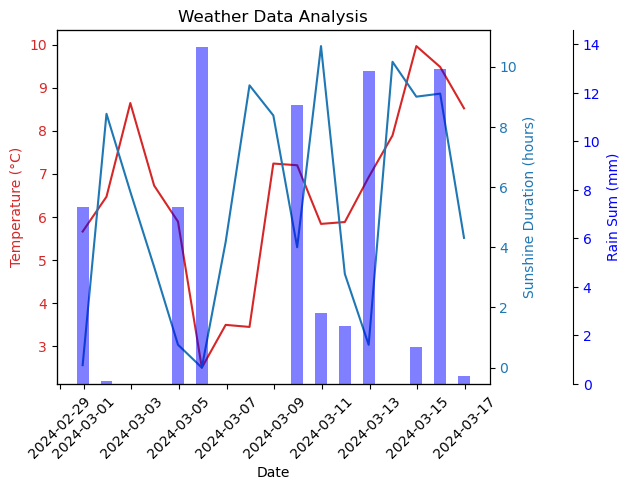

In [ ]:
import openmeteo_requests

import matplotlib.pyplot as plt
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": latitude,
	"longitude": longitude,
	"start_date": "2024-03-01",
	"end_date": "2024-03-17",
	"daily": ["temperature_2m_mean", "sunshine_duration", "rain_sum"],
	"timezone": "Europe/Berlin"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")



# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()
daily_sunshine_duration = daily.Variables(1).ValuesAsNumpy()
daily_rain_sum = daily.Variables(2).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["sunshine_duration"] = daily_sunshine_duration /3600
daily_data["rain_sum"] = daily_rain_sum

daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe)

# Plotting
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
plt.xticks(rotation=45)
ax1.set_ylabel('Temperature (°C)', color=color)
ax1.plot(daily_dataframe['date'], daily_dataframe['temperature_2m_mean'], color=color, label='Temperature')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Sunshine Duration (hours)', color=color)
ax2.plot(daily_dataframe['date'], daily_dataframe['sunshine_duration'], color=color, label='Sunshine Duration')
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a third axes for the rain sum
ax3.spines['right'].set_position(('outward', 60))  # Offset the right spine of ax3
color = 'tab:green'
ax3.set_ylabel('Rain Sum (mm)', color= "blue")
ax3.bar(daily_dataframe['date'], daily_dataframe['rain_sum'], color="blue", label='Rain Sum', alpha=0.5, width=0.5)
ax3.tick_params(axis='y', labelcolor="blue")

# Otherwise the right y-label is slightly clipped
fig.tight_layout()
plt.title('Weather Data Analysis')
plt.show()


In [ ]:
#Because my lovely group doesn't recognise my amazing work, I've finally implemented a clickable and interactive graph with Plotly.

In [ ]:
#install the following environment via your terminal.

#pip install plotly

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Assuming daily_dataframe is already created as per your Matplotlib example

# Create a subplot with 2 y-axes on the left and 1 y-axis on the right
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add temperature plot on primary y-axis
fig.add_trace(
    go.Scatter(x=daily_dataframe['date'], y=daily_dataframe['temperature_2m_mean'],
               name='Temperature (°C)', mode='lines', line=dict(color='red')),
    secondary_y=False,
)

# Add sunshine duration plot on secondary y-axis (left)
fig.add_trace(
    go.Scatter(x=daily_dataframe['date'], y=daily_dataframe['sunshine_duration'],
               name='Sunshine Duration (hours)', mode='lines', line=dict(color='blue')),
    secondary_y=True,
)

# Since Plotly does not directly support a third y-axis, we use a bar chart to represent the rain sum
# This will overlay on the primary y-axis but can be visually distinguished
fig.add_trace(
    go.Bar(x=daily_dataframe['date'], y=daily_dataframe['rain_sum'],
           name='Rain Sum (mm)', marker_color='green', opacity=0.5),
    secondary_y=False,
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Temperature (°C)", secondary_y=False, color='red')
fig.update_yaxes(title_text="Sunshine Duration (hours)", secondary_y=True, color='blue')

# Set layout options
fig.update_layout(
    title_text="Weather Data Analysis",
    xaxis_tickangle=-45,
    legend=dict(orientation="h"),
)

# Show plot
fig.show()


In [ ]:
#I hope my team is happy now.